In [2]:
from openfermion.hamiltonians import MolecularData, load_molecular_hamiltonian
from openfermion.ops import FermionOperator
from openfermion.transforms import bravyi_kitaev
from openfermion.utils import hermitian_conjugated
from openfermion.ops import QubitOperator
from forestopenfermion import pyquilpauli_to_qubitop, qubitop_to_pyquilpauli
from pyquil.paulis import PauliSum
from pyquil.api import WavefunctionSimulator
from scipy.optimize import minimize
from pyquil import Program
from pyquil.gates import *

import numpy as np
import functools

In [3]:
sim = WavefunctionSimulator()

In [4]:
numQubit = 4
class Track:
    def __init__(self):
        self.cnt = 0

def solve_vqe(hamiltonian: PauliSum, numLayer) -> float:
    # Construct a variational quantum eigensolver solution to find the lowest
    # eigenvalue of the given hamiltonian
    
    theta_init = np.random.rand(2*numQubit*numLayer) * 2 * np.pi
    
    track = Track()

    def inc(t, xk):
        t.cnt += 1

    def ansatz_energy(t, theta_vec):
        t.cnt += 1
        p = None
        p = Program()
        for j in range(numLayer):
            for i in range(numQubit):
                p += RX(theta_vec[2*numQubit * j + 2 * i], i)
                p += RZ(theta_vec[2*numQubit * j + 2 * i + 1], i)
            for i in range(numQubit - 1):
                p += CNOT(i, i + 1)

        energy = sim.expectation(p, hamiltonian).real
        return energy

    theta_answer = minimize(functools.partial(ansatz_energy, track), theta_init, method='L-BFGS-B').x
    print(theta_answer)
    return ansatz_energy(track, theta_answer), track.cnt

In [5]:
def get_ground_energy(interaction_hamil, numLayer):
    fermionop_hamil = FermionOperator()
    for key in interaction_hamil:
        value = interaction_hamil[key]
        fermionop_hamil += FermionOperator(term=key, coefficient=value)
        
    qubitop_hamil = bravyi_kitaev(fermionop_hamil)
    pauliop_hamil = qubitop_to_pyquilpauli(qubitop_hamil)
    
    sim = WavefunctionSimulator()
    return solve_vqe(pauliop_hamil, numLayer)


In [15]:
basis = 'sto-3g'
multiplicity = 1  # 2S+1
charge = 0

import matplotlib.pyplot as plt
%matplotlib inline

bond_lengths = np.linspace(0.3, 2.5, 23)
vqe_ground_energies_mean = []
vqe_ground_energies_min = []
vqe_ground_energies_std = []
vqe_iter_mean = []
vqe_iter_std = []

for layer in [1,2,3,4,5]:
    gelist = []
    gelist2 = []
    gestdlist = []
    iterlist = []
    iterstdlist = []
    for bond_length in bond_lengths:
        geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
        description = str(round(bond_length, 2))
        h2_interaction_hamil = load_molecular_hamiltonian(geometry,
            basis,
            multiplicity,
            description,
            n_active_electrons=None,
            n_active_orbitals=None)

        gelist_temp = []
        iterlist_temp = []
        for i in range(10):
            ge, cnt = get_ground_energy(h2_interaction_hamil, layer)
            print('bond length: ', round(bond_length, 2), ' ground state energy: ', ge, ' iteration: ', cnt)
            gelist_temp.append(ge)
            iterlist_temp.append(cnt)
        gelist.append(np.mean(gelist_temp))
        gelist2.append(min(gelist_temp))
        gestdlist.append(np.std(gelist_temp))
        iterlist.append(np.mean(iterlist_temp))
        iterstdlist.append(np.std(iterlist_temp))
        
    vqe_ground_energies_mean.append(gelist)
    vqe_ground_energies_min.append(gelist2)
    vqe_ground_energies_std.append(gestdlist)
    vqe_iter_mean.append(np.mean(iterlist))
    vqe_iter_std.append(np.mean(iterstdlist))


bond length:  0.3  ground state energy:  -0.5938277644091574  iteration:  118
bond length:  0.3  ground state energy:  0.20903885412892453  iteration:  118
bond length:  0.3  ground state energy:  -0.5938277645442739  iteration:  172
bond length:  0.3  ground state energy:  0.20903885413141968  iteration:  190
bond length:  0.3  ground state energy:  -0.5938277645832803  iteration:  127
bond length:  0.3  ground state energy:  -0.5938277645003576  iteration:  127
bond length:  0.3  ground state energy:  -0.5938277645306469  iteration:  127
bond length:  0.3  ground state energy:  0.20903885416559792  iteration:  91
bond length:  0.3  ground state energy:  0.20903885420784152  iteration:  127
bond length:  0.3  ground state energy:  -0.5938277645780885  iteration:  154
bond length:  0.4  ground state energy:  -0.9043613977134963  iteration:  127
bond length:  0.4  ground state energy:  -0.9043613976830052  iteration:  145
bond length:  0.4  ground state energy:  -0.1591488643910256  ite

bond length:  1.3  ground state energy:  -0.855236942082929  iteration:  127
bond length:  1.3  ground state energy:  -0.8552369420814206  iteration:  109
bond length:  1.3  ground state energy:  -0.973110613949076  iteration:  424
bond length:  1.3  ground state energy:  -0.9731106139443346  iteration:  181
bond length:  1.4  ground state energy:  -0.8754279400532741  iteration:  91
bond length:  1.4  ground state energy:  -0.8754279399091888  iteration:  82
bond length:  1.4  ground state energy:  -0.8754279400533432  iteration:  109
bond length:  1.4  ground state energy:  -0.9414806527124194  iteration:  388
bond length:  1.4  ground state energy:  -0.9414806527389131  iteration:  109
bond length:  1.4  ground state energy:  -0.9414806524812741  iteration:  316
bond length:  1.4  ground state energy:  -0.9414806525883266  iteration:  136
bond length:  1.4  ground state energy:  -0.8754279400345759  iteration:  136
bond length:  1.4  ground state energy:  -0.8754279400510252  iterat

bond length:  2.4  ground state energy:  -0.9309808721634716  iteration:  91
bond length:  2.4  ground state energy:  -0.9309808721721664  iteration:  181
bond length:  2.4  ground state energy:  -0.7159100566568452  iteration:  136
bond length:  2.4  ground state energy:  -0.9309808721787209  iteration:  136
bond length:  2.4  ground state energy:  -0.9309808721492359  iteration:  298
bond length:  2.4  ground state energy:  -0.9309808721781909  iteration:  217
bond length:  2.4  ground state energy:  -0.9309808720325953  iteration:  91
bond length:  2.4  ground state energy:  -0.9309808721817351  iteration:  100
bond length:  2.5  ground state energy:  -0.702943597557996  iteration:  154
bond length:  2.5  ground state energy:  -0.9316390865666534  iteration:  100
bond length:  2.5  ground state energy:  -0.9316390867074957  iteration:  118
bond length:  2.5  ground state energy:  -0.9316390867902875  iteration:  109
bond length:  2.5  ground state energy:  -0.9316390867032589  itera

bond length:  1.1  ground state energy:  -1.079192943803114  iteration:  409
bond length:  1.1  ground state energy:  -0.7929596994355375  iteration:  392
bond length:  1.2  ground state energy:  -0.8284433473552718  iteration:  426
bond length:  1.2  ground state energy:  -1.0567407449313566  iteration:  392
bond length:  1.2  ground state energy:  -1.0567407450585893  iteration:  341
bond length:  1.2  ground state energy:  -0.8284433481203687  iteration:  358
bond length:  1.2  ground state energy:  -1.0567407449770911  iteration:  392
bond length:  1.2  ground state energy:  -0.828443348088128  iteration:  239
bond length:  1.2  ground state energy:  -0.8284433477419229  iteration:  358
bond length:  1.2  ground state energy:  -0.8284433481281795  iteration:  222
bond length:  1.2  ground state energy:  -1.0567407451244668  iteration:  341
bond length:  1.2  ground state energy:  -0.8284433480633578  iteration:  273
bond length:  1.3  ground state energy:  -0.8552369407692885  iter

bond length:  2.2  ground state energy:  -0.9287736351223461  iteration:  222
bond length:  2.2  ground state energy:  -0.9287736342815427  iteration:  239
bond length:  2.2  ground state energy:  -0.9287736351136469  iteration:  205
bond length:  2.2  ground state energy:  -0.9412240332755608  iteration:  528
bond length:  2.2  ground state energy:  -0.928773634418732  iteration:  494
bond length:  2.2  ground state energy:  -0.9287736347270079  iteration:  307
bond length:  2.3  ground state energy:  -0.9300586378629305  iteration:  239
bond length:  2.3  ground state energy:  -0.9389223854367633  iteration:  511
bond length:  2.3  ground state energy:  -0.9300586384489464  iteration:  273
bond length:  2.3  ground state energy:  -0.9300586383028852  iteration:  545
bond length:  2.3  ground state energy:  -0.9300586385873996  iteration:  443
bond length:  2.3  ground state energy:  -0.9300586377842687  iteration:  290
bond length:  2.3  ground state energy:  -0.9389223851079374  ite

bond length:  1.0  ground state energy:  -1.1011503292062232  iteration:  676
bond length:  1.0  ground state energy:  -1.101150329114392  iteration:  726
bond length:  1.0  ground state energy:  -1.1011503290154447  iteration:  626
bond length:  1.0  ground state energy:  -1.1011503242259923  iteration:  1301
bond length:  1.0  ground state energy:  -1.101150328665078  iteration:  976
bond length:  1.0  ground state energy:  -1.1011503292648452  iteration:  701
bond length:  1.0  ground state energy:  -1.1011503291355127  iteration:  1226
bond length:  1.0  ground state energy:  -0.7458717947184104  iteration:  776
bond length:  1.0  ground state energy:  -0.7458717945891482  iteration:  851
bond length:  1.0  ground state energy:  -1.101150329169594  iteration:  951
bond length:  1.1  ground state energy:  -0.7929596990155342  iteration:  476
bond length:  1.1  ground state energy:  -1.0791929417186812  iteration:  976
bond length:  1.1  ground state energy:  -0.7929596956369633  ite

bond length:  2.0  ground state energy:  -0.9486411115896402  iteration:  2476
bond length:  2.0  ground state energy:  -0.9245373193261692  iteration:  501
bond length:  2.0  ground state energy:  -0.9486411108063308  iteration:  1151
bond length:  2.0  ground state energy:  -0.9245373187773893  iteration:  926
bond length:  2.0  ground state energy:  -0.9486411115106744  iteration:  1326
bond length:  2.1  ground state energy:  -0.9269926921331932  iteration:  551
bond length:  2.1  ground state energy:  -0.9443746173108847  iteration:  1751
bond length:  2.1  ground state energy:  -0.9269926917093383  iteration:  601
bond length:  2.1  ground state energy:  -0.9443746804417534  iteration:  876
bond length:  2.1  ground state energy:  -0.9269926844380565  iteration:  801
bond length:  2.1  ground state energy:  -0.9443746807149507  iteration:  2001
bond length:  2.1  ground state energy:  -0.9443746800541405  iteration:  3151
bond length:  2.1  ground state energy:  -0.94437468029039

bond length:  0.8  ground state energy:  -1.1341476660591856  iteration:  1156
bond length:  0.8  ground state energy:  -1.1341476662442733  iteration:  991
bond length:  0.8  ground state energy:  -1.13414766611987  iteration:  1816
bond length:  0.8  ground state energy:  -1.134147665970571  iteration:  892
bond length:  0.8  ground state energy:  -1.1341476660805467  iteration:  1156
bond length:  0.8  ground state energy:  -1.1341476658790028  iteration:  1255
bond length:  0.8  ground state energy:  -1.1341476662508385  iteration:  1486
bond length:  0.8  ground state energy:  -1.1341476656888492  iteration:  661
bond length:  0.8  ground state energy:  -1.1341476661876606  iteration:  760
bond length:  0.8  ground state energy:  -1.134147656647444  iteration:  1651
bond length:  0.9  ground state energy:  -1.1205602782271689  iteration:  1684
bond length:  0.9  ground state energy:  -1.1205602791749472  iteration:  1057
bond length:  0.9  ground state energy:  -1.1205602728589679

bond length:  1.8  ground state energy:  -0.916574905856061  iteration:  991
bond length:  1.8  ground state energy:  -0.9618169059156187  iteration:  1783
bond length:  1.8  ground state energy:  -0.96181694913323  iteration:  1849
bond length:  1.8  ground state energy:  -0.9618169489154222  iteration:  2476
bond length:  1.8  ground state energy:  -0.9618169496891738  iteration:  1585
bond length:  1.9  ground state energy:  -0.9211697320953871  iteration:  793
bond length:  1.9  ground state energy:  -0.9543388433086224  iteration:  1948
bond length:  1.9  ground state energy:  -0.9543388476464478  iteration:  3037
bond length:  1.9  ground state energy:  -0.9211697328820472  iteration:  892
bond length:  1.9  ground state energy:  -0.9211696903459847  iteration:  2410
bond length:  1.9  ground state energy:  -0.921169733488621  iteration:  595
bond length:  1.9  ground state energy:  -0.9543388292605691  iteration:  3136
bond length:  1.9  ground state energy:  -0.9543388519516545

bond length:  0.6  ground state energy:  -1.1162860023594892  iteration:  3199
bond length:  0.6  ground state energy:  -1.1162859990956795  iteration:  3568
bond length:  0.6  ground state energy:  -1.1162860023078387  iteration:  3568
bond length:  0.6  ground state energy:  -1.1162860020256467  iteration:  6356
bond length:  0.6  ground state energy:  -1.1162857783895694  iteration:  3527
bond length:  0.6  ground state energy:  -1.1162860067644054  iteration:  2420
bond length:  0.6  ground state energy:  -1.11628598268298  iteration:  3691
bond length:  0.6  ground state energy:  -1.116285994926244  iteration:  5741
bond length:  0.6  ground state energy:  -1.1162859884333223  iteration:  3937
bond length:  0.6  ground state energy:  -1.1162859725732124  iteration:  5249
bond length:  0.7  ground state energy:  -1.1361894117175817  iteration:  2994
bond length:  0.7  ground state energy:  -1.1361891643992186  iteration:  3609
bond length:  0.7  ground state energy:  -1.13618926168

bond length:  1.6  ground state energy:  -0.9834727266158816  iteration:  3773
bond length:  1.6  ground state energy:  -0.9834727252205476  iteration:  2010
bond length:  1.6  ground state energy:  -0.983472476386543  iteration:  3158
bond length:  1.6  ground state energy:  -0.9834725728717348  iteration:  4019
bond length:  1.6  ground state energy:  -0.9834727221167978  iteration:  2338
bond length:  1.6  ground state energy:  -0.9834726851053822  iteration:  2420
bond length:  1.7  ground state energy:  -0.9103374306034047  iteration:  2502
bond length:  1.7  ground state energy:  -0.9714266863427254  iteration:  2584
bond length:  1.7  ground state energy:  -0.971426684101781  iteration:  3117
bond length:  1.7  ground state energy:  -0.9714266671013015  iteration:  2953
bond length:  1.7  ground state energy:  -0.910337423399015  iteration:  2092
bond length:  1.7  ground state energy:  -0.9714266246523295  iteration:  1969
bond length:  1.7  ground state energy:  -0.91033743084

In [19]:
print(vqe_ground_energies_mean)
print(vqe_ground_energies_min)
print(vqe_iter_mean)

[[-0.2726811170512021, -0.5317551310467092, -0.6975851127296138, -0.7166024844675836, -0.8791636463837647, -0.9567486195184338, -0.9282881820273335, -0.8099191658827862, -0.8903913689979162, -0.9521076976956646, -0.902386410818718, -0.9018490250518756, -0.8966714132965692, -0.8918221339814469, -0.8991374720081188, -0.8639388502779404, -0.8748349773075959, -0.8963883859050308, -0.8944296836299509, -0.9105364062055544, -0.8501765109734709, -0.9094737906033862, -0.8858999889814075], [-0.4396352025850514, -0.7631495393079438, -0.9567178287198723, -0.8746882344205383, -1.0089853931542492, -0.8119657492820913, -0.9454759262541998, -0.923511061271291, -0.9074529970663155, -0.9197623067588733, -0.9272166709765324, -0.8754279391529026, -0.9228541523835625, -0.9100679084881517, -0.9164463589177145, -0.9301475177698734, -0.9311204693992959, -0.9317684563203965, -0.9304690895818277, -0.9300186747290204, -0.9318313876765766, -0.9309808715463694, -0.9325222531083158], [-0.6018036885552295, -0.914149

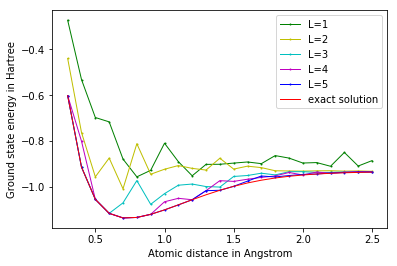

In [17]:
# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
bond_lengths = []
for bond_length in np.linspace(0.3, 2.5, 23):
    bond_lengths += [bond_length]
    description = str(round(bond_length,2))
#    print(description)
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity, description=description)
    
    # Load data.
    molecule.load()
    fci_energies += [molecule.fci_energy]
    hf_energies += [molecule.hf_energy]

plt.figure(0)
plt.plot(bond_lengths, vqe_ground_energies_mean[0], 'go-', linewidth=1, markersize=1, label='L=1')
plt.plot(bond_lengths, vqe_ground_energies_mean[1], 'yo-', linewidth=1, markersize=1, label='L=2')
plt.plot(bond_lengths, vqe_ground_energies_mean[2], 'co-', linewidth=1, markersize=1, label='L=3')
plt.plot(bond_lengths, vqe_ground_energies_mean[3], 'mo-', linewidth=1, markersize=1, label='L=4')
plt.plot(bond_lengths, vqe_ground_energies_mean[4], 'bo-', linewidth=1, markersize=1, label='L=5')
plt.plot(bond_lengths, fci_energies, 'r-', linewidth=1, markersize=1, label='exact solution')
plt.legend()
plt.ylabel('Ground state energy in Hartree')
plt.xlabel('Atomic distance in Angstrom')
plt.savefig('PLOT1.pdf', bbox_inches='tight')
plt.show()

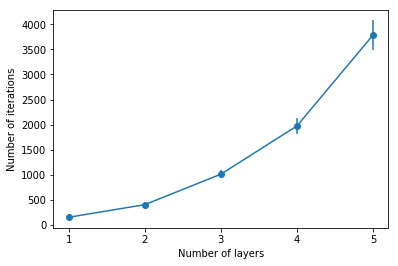

[151.7695652173913, 402.71739130434776, 1011.2173913043479, 1973.2521739130432, 3788.1521739130435]
[  6677.86086957  20941.30434783  60673.04347826 134181.14782609
 287899.56521739]
[0.8361903675267521, 0.8993344499574178, 0.970730835262741, 0.985422124759957, 0.99743016377654]
[-0.02999042667582158, -0.02510043644534071, -0.010595365709448698, -0.006457710178367466, -0.0013435138404102615]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


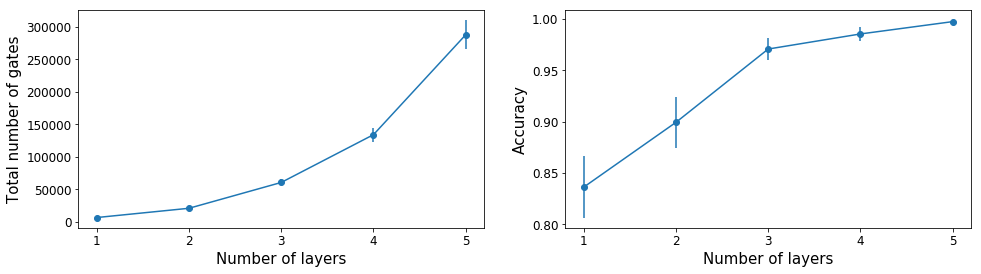

In [22]:
#plt.plot([1,2,3,4,5], vqe_iter_mean, 'o-')
plt.xticks(np.arange(0, 6, step=1))
plt.errorbar([1,2,3,4,5], vqe_iter_mean, vqe_iter_std/np.sqrt(23), marker='o', linestyle=None)
plt.ylabel('Number of iterations')
plt.xlabel('Number of layers')
plt.show()
print(vqe_iter_mean)

f = plt.figure(figsize=(16,4))
ax = f.add_subplot(121)
plt.xticks(np.arange(0, 6, step=1))
ax.tick_params(labelsize = 12)
numGates = 36+8*np.array([1,2,3,4,5])
totalNumGates = np.array(vqe_iter_mean)*numGates
ax.errorbar([1,2,3,4,5], totalNumGates, vqe_iter_std/np.sqrt(23)*numGates, marker='o', linestyle=None)
plt.ylabel('Total number of gates', size=15)
plt.xlabel('Number of layers', size=15)
print(np.array(vqe_iter_mean)*numGates)

accuracy = []
error = []
for i in range(5):
    acc = 1-np.abs(np.mean((np.array(vqe_ground_energies_mean[i])-np.array(fci_energies))/np.array(fci_energies)))
    err = np.mean(vqe_ground_energies_std[i]/np.array(fci_energies))/np.sqrt(23)
    accuracy.append(acc)
    error.append(err)
print(accuracy)
print(error)
ax2 = f.add_subplot(122)
plt.xticks(np.arange(0, 6, step=1))
plt.yticks(np.arange(0.8, 1.05, step = 0.05))
ax2.tick_params(labelsize = 12)
ax2.errorbar([1,2,3,4,5], accuracy, error, marker='o')
plt.ylabel('Accuracy', size=15)
plt.xlabel('Number of layers', size=15)

f.show()
f.savefig('PLOT2.pdf', bbox_inches='tight')


In [30]:
basis = 'sto-3g'
multiplicity = 1  # 2S+1
charge = 0

import matplotlib.pyplot as plt
%matplotlib inline

bond_lengths = np.linspace(0.3, 2.5, 23)
layer=4

gelist_layer4 = []

for bond_length in bond_lengths:
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    description = str(round(bond_length, 2))
    h2_interaction_hamil = load_molecular_hamiltonian(geometry,
        basis,
        multiplicity,
        description,
        n_active_electrons=None,
        n_active_orbitals=None)

    gelist_temp = []
    for i in range(10):
        ge, cnt = get_ground_energy(h2_interaction_hamil, layer)
        print('bond length: ', round(bond_length, 2), ' ground state energy: ', ge, ' iteration: ', cnt)
        gelist_temp.append(ge)
    gelist_layer4.append(min(gelist_temp))
        
print(gelist_layer4)

bond length:  0.3  ground state energy:  -0.601803716745519  iteration:  50
bond length:  0.3  ground state energy:  -0.6018037150718262  iteration:  36
bond length:  0.3  ground state energy:  -0.6018037163349372  iteration:  33
bond length:  0.3  ground state energy:  -0.6018037160632721  iteration:  42
bond length:  0.3  ground state energy:  -0.6018037133499453  iteration:  48
bond length:  0.3  ground state energy:  -0.6018037163209089  iteration:  44
bond length:  0.3  ground state energy:  -0.6018037167006471  iteration:  28
bond length:  0.3  ground state energy:  -0.6018037121454229  iteration:  64
bond length:  0.3  ground state energy:  -0.6018037100143121  iteration:  53
bond length:  0.3  ground state energy:  -0.6018037142628473  iteration:  35
bond length:  0.4  ground state energy:  -0.9141497080315906  iteration:  42
bond length:  0.4  ground state energy:  -0.9141497074520964  iteration:  36
bond length:  0.4  ground state energy:  -0.9141495003599979  iteration:  113

bond length:  1.3  ground state energy:  -0.9452116019962314  iteration:  34
bond length:  1.3  ground state energy:  -1.0351862573288897  iteration:  32
bond length:  1.3  ground state energy:  -1.0351862646872783  iteration:  44
bond length:  1.4  ground state energy:  -1.0154682438944538  iteration:  45
bond length:  1.4  ground state energy:  -1.015468213640319  iteration:  31
bond length:  1.4  ground state energy:  -1.0154682420791203  iteration:  60
bond length:  1.4  ground state energy:  -1.0154682446889678  iteration:  60
bond length:  1.4  ground state energy:  -1.015468243797469  iteration:  70
bond length:  1.4  ground state energy:  -1.0154682451710395  iteration:  49
bond length:  1.4  ground state energy:  -1.015468244744815  iteration:  41
bond length:  1.4  ground state energy:  -1.015468245383837  iteration:  72
bond length:  1.4  ground state energy:  -1.0154682399846717  iteration:  27
bond length:  1.4  ground state energy:  -1.0154682376301771  iteration:  71
bon

bond length:  2.4  ground state energy:  -0.9309808698957015  iteration:  32
bond length:  2.4  ground state energy:  -0.9372545004529687  iteration:  89
bond length:  2.4  ground state energy:  -0.9372547633251008  iteration:  112
bond length:  2.4  ground state energy:  -0.9372549485194255  iteration:  89
bond length:  2.4  ground state energy:  -0.9372546122564795  iteration:  55
bond length:  2.4  ground state energy:  -0.9372549501160172  iteration:  100
bond length:  2.5  ground state energy:  -0.9316390853890861  iteration:  41
bond length:  2.5  ground state energy:  -0.936054669298372  iteration:  91
bond length:  2.5  ground state energy:  -0.9360548706376669  iteration:  114
bond length:  2.5  ground state energy:  -0.9316390579607687  iteration:  61
bond length:  2.5  ground state energy:  -0.9316391404557065  iteration:  37
bond length:  2.5  ground state energy:  -0.9360547896722964  iteration:  144
bond length:  2.5  ground state energy:  -0.9316390858002062  iteration: 

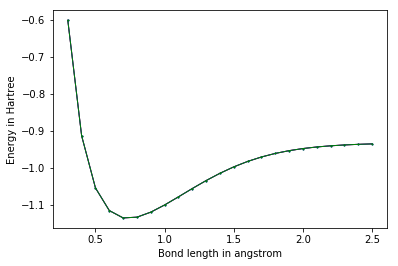

In [24]:
vqe_qvm_layer4 = [-0.601803716745519, -0.9141497081684253, -1.0551597964655266, -1.1162860074101357, -1.1361894541959934, -1.1341476662727625, -1.1205602805140038, -1.1011503292241223, -1.0791929438432515, -1.0567407449017003, -1.0351862646872783, -1.015468245383837, -0.9981493519957572, -0.9834727274204723, -0.9714266871033888, -0.9618169511243723, -0.9543388530562406, -0.9486411105719305, -0.9443746793529314, -0.9412240320055978, -0.9389223816166299, -0.9372549501160172, -0.9360549185349424]
vqe_qpu_layer4 = [-0.6018037166564036, -0.914149708163514, -1.0551597964281025, -1.1162860077553365, -1.1361894542040014, -1.1341476659825447, -1.1205602805384873, -1.1011503283456041, -1.0791929433530079, -1.0567407447701214, -1.0351862645877297, -1.0154682478158483, -0.9981493520166305, -0.9834727269324907, -0.9714266863152411, -0.9618169517803161, -0.9543388526835397, -0.9486411104958775, -0.9443746805634903, -0.9412240329858607, -0.9389223849087819, -0.9372549521617642, -0.9360549171663575]


plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'r-', linewidth=1, markersize=1)
plt.plot(bond_lengths, vqe_qvm_layer4, 'bo-', linewidth=1, markersize=1)
plt.plot(bond_lengths, vqe_qpu_layer4, 'go-', linewidth=1, markersize=1)
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()

In [6]:
basis = 'sto-3g'
multiplicity = 1  # 2S+1
charge = 0

import matplotlib.pyplot as plt
%matplotlib inline

bond_lengths = [0.7] # np.linspace(0.3, 2.5, 23)
layer=3

gelist_layer3 = []

for bond_length in bond_lengths:
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    description = str(round(bond_length, 2))
    h2_interaction_hamil = load_molecular_hamiltonian(geometry,
        basis,
        multiplicity,
        description,
        n_active_electrons=None,
        n_active_orbitals=None)

    gelist_temp = []
    for i in range(10):
        ge, cnt = get_ground_energy(h2_interaction_hamil, layer)
        print('bond length: ', round(bond_length, 2), ' ground state energy: ', ge, ' iteration: ', cnt)
        gelist_temp.append(ge)
    gelist_layer3.append(min(gelist_temp))
        
print(gelist_layer3)

[ 6.28318850e+00  2.69627327e+00  3.64859364e-06  1.71306484e+00
  2.00379986e+00  2.87101111e+00  2.97499472e+00 -6.08056399e-04
  2.93184856e+00  2.20587629e+00  3.14159630e+00  1.78474312e+00
  3.14173900e+00  1.79790161e+00  6.44982876e+00  1.07299533e+00
  6.28317088e+00  6.62561448e-01  3.14155614e+00  5.39277594e+00
  1.13776729e+00  3.03874155e+00 -1.87878622e-04  6.79330935e+00]
bond length:  0.7  ground state energy:  -1.1361894510634285  iteration:  976
[1.59936773e+00 2.26456495e+00 3.05338147e+00 5.12623801e+00
 7.85398388e+00 1.57080465e+00 6.28319486e+00 4.98687594e+00
 3.11498445e+00 3.90999363e+00 3.39064388e+00 1.64721771e+00
 3.32550232e+00 4.69284832e+00 2.94447258e+00 3.16112741e+00
 4.68456968e+00 3.53381332e+00 1.41159255e-06 4.98707411e-01
 4.71238092e+00 6.37926561e+00 3.12835849e+00 5.90640854e+00]
bond length:  0.7  ground state energy:  -1.1361894144967872  iteration:  1001
[2.04164171 4.38635868 3.0888839  1.59973312 1.57078062 1.57080307
 4.25294823 3.1415

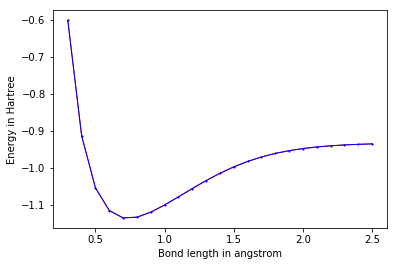

In [33]:
plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'rx-', linewidth=1, markersize=1)
plt.plot(bond_lengths, gelist_layer3, 'bo-', linewidth=1, markersize=1)
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()